<a href="https://colab.research.google.com/github/rashmi05pathak/CS6910_Assignment1/blob/main/EE20S051_ED21S007_DL_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Deep Learning Assignment 1 - Fashion MNIST dataset**

In [69]:
!pip install wandb
!pip install scikit-plot

#**Libraries**

In [70]:
import numpy as np
import pandas as pd
import keras
import math
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb
import tensorflow as tf
import tensorflow_datasets as tdfs
from sklearn.metrics import accuracy_score
import scikitplot as skplt
from sklearn.metrics import confusion_matrix

**Visualizing Dataset**

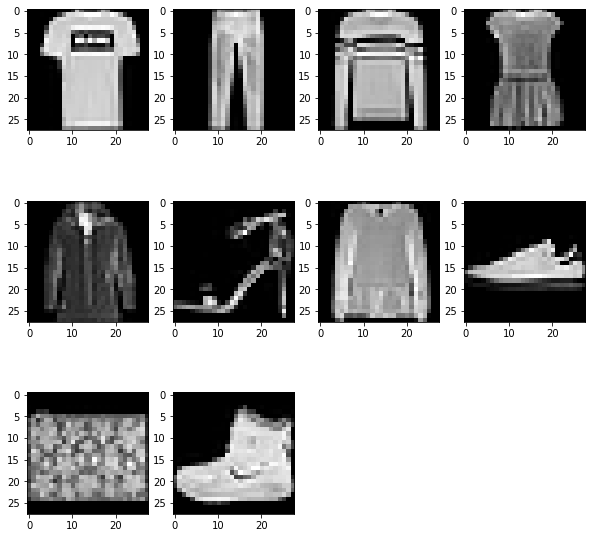

In [71]:
# getting one sample image from each class and visualizing 
(trainx, trainy), (testx, testy)= fashion_mnist.load_data()
classes = np.unique(trainy)
index_mat = [0]*10
for i in classes:
  index_mat[i] = trainy.tolist().index(i)

plt.figure(figsize=(10,10))

for j, i in enumerate(index_mat):
  plt.subplot(3,4,j+1)
  plt.imshow(trainx[i], cmap=plt.get_cmap('gray'))
  
plt.show()

In [72]:
class_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [73]:
#display images with names in wandb 
#uncomment the following lines logging images in wandb
wandb.init(entity='rashmi05pathak',project='Assignment_try1')
wandb.log({'sample':[wandb.Image(trainx[i],caption=class_names[trainy[i]]) for i in index_mat]})

accuracy,▁▂▂▃▄▅▅▆▆▇▇▇███
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,██▇▅▄▄▃▃▃▂▂▂▁▁▁
val_accuracy,▁▂▂▃▄▅▅▆▆▇▇▇███
val_loss,██▇▅▄▄▃▃▂▂▂▂▁▁▁
accuracy,0.77846
epoch,14
loss,0.65053
val_accuracy,0.77617
val_loss,0.65806


In [88]:
class_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

#normalising input x

x_train = trainx.reshape(60000,784)/255.0
x_test=testx.reshape(10000,784)/255.0
y_test=testy
#one hot encoding y train
temp = np.zeros((60000,10))
temp[np.arange(60000),trainy] = 1
y_train=temp

**Define hyperparameters**

In [75]:
# hyperparameters to be used for training
config_defaults = {
        'epochs': 15,
        'batch_size':32,
        'hidden_layers':4,
        'eta': 0.001,
        'size':32,
        'activation': 'sigmoid',      
        'optimizer': 'sgd',       
        'wt_decay':0.05,
        'wt_init':'xavier'
        }

config=config_defaults  

In [35]:
#hyperparameters config used for wandb sweep using grid search
sweep_config = {
  'name': 'sweep6',  
  'method': 'grid',
  'parameters': {
        'epochs': {
            'values': [5]
        },
        'batch_size':{
            'values':[32]
        },
        'hidden_layers':{
            'values':[3,4]
        },
        'eta': {
            'values': [0.005]
        },
        'size':{
            'values':[32,64]
        },
        'optimizer': {
            'values': ['adam','rmsprop']
        },
        'activation': {
            'values': ['sigmoid','tanh','relu']
        },
        'wt_decay': {
            'values': [0.005,0.05]
        },
        'wt_init':{
            'values':['xavier','random']
        }
    }
}

In [76]:
sweep_config = {
        'method': 'bayes',
        "name": "assignement1-Sweep2",
        'metric':{
            'goal': 'maximize',
            'name': 'val_accuracy'
        },
        'parameters': {
        'epochs': {
            'values': [5,10,15]
        },
        'no_hidden_layers':{
            'values': [3,4,5]
        },
        'size_hidden_layers':{
            'values': [64,128]
        },
        'learning_rate':{
            'values': [0.001,0.01,0.0001,0.05,0.02]
        },
        'optimizer':{
            'values': ['momentum','sgd','rmsprop','nesterov','adam']
        },
        'batch_size':{
            'values': [32,64,128]
        },
        'activation':{
            'values': ['sigmoid','tanh','Relu']
        },
        'weight_initializations':{
            'values': ['random','xavier']
        },
        'weight_decay':{
            'values': [0,0.0005,0.05]
        }

    }
    }

In [10]:
config

{'activation': 'sigmoid',
 'batch_size': 32,
 'epochs': 10,
 'eta': 0.001,
 'hidden_layers': 3,
 'optimizer': 'rmsprop',
 'size': 32,
 'wt_decay': 0.05,
 'wt_init': 'xavier'}

**Activation function definitions** **And Weight-bias initialization**

In [77]:
#Defining activation functions and their derivatives

def sigmoid(x):
  return 1/(1+np.exp(-x))

def tanh(x):
  return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def relu(x):
  t=np.array((np.maximum(0,x)),dtype=np.longdouble)
  return t

def grad_tanh(x):
  return 1-(tanh(x))**2

def grad_relu(x):
  t = np.where(x < 0, 0, x)
  return t

def grad_sigmoid(x):
  return (sigmoid(x)*(1-sigmoid(x)))

def softmax(x):
  exps = np.exp(x )
  return exps / np.sum(exps)

#Defining initialization of weight and bias: random and xavier initialization
def init_random(num_weight_mat,num_nodes):
    weights={}
    bias = {}
    for i in  range(1,num_weight_mat+1):
      weights['W%s'% i] = np.random.randn(int(num_nodes[i]),int(num_nodes[i-1]))
      bias['b%s'% i] = np.random.randn(int(num_nodes[i]))
    
    return weights, bias

def init_xavier(num_weight_mat,num_nodes):
    weights={}
    bias = {}
    for i in  range(1,num_weight_mat+1):
      weights['W%s'%i] = np.random.normal(0, math.sqrt(1/num_nodes[i-1]) ,size=([int(num_nodes[i]),int(num_nodes[i-1])]))
      bias['b%s'%i] = np.zeros(int(num_nodes[i]))
    
    return weights, bias

def init_zeros(num_weight_mat,num_nodes):
    #print(num_weight_mat)
    weights={}
    bias = {}
    for i in  range(1,num_weight_mat+1):
      weights['W%s'% i] = np.zeros([int(num_nodes[i]),int(num_nodes[i-1])])
      bias['b%s'% i] = np.zeros(int(num_nodes[i]))

    return weights,bias

In [78]:
#Setting activation function and its derivative
activation_fun = config['activation']
if activation_fun == 'sigmoid':
    activ = sigmoid
    der_activ = grad_sigmoid
elif activation_fun == 'tanh':
    activ = tanh
    der_activ = grad_tanh
elif activation_fun == 'relu':
    activ = relu
    der_activ = grad_relu

#Setting output function
output = softmax 
activation = activ
  

#Forward propogation
def forward_propogation(weights, bias, x):
    num_weight_mat = len(weights)
    num_hidden_layers = num_weight_mat-1
    Acti = {}
    H = {}
    
    H['H0'] = x
    
    for i in range(1,num_hidden_layers+1):
      Acti[('A%s'% i)] = np.matmul(weights['W%s'% i],H[('H%s'% (i-1))])+bias['b%s'% i]
      H['H%s'% i] = activation(Acti['A%s'% i])
    
    Acti['A%s'%(num_hidden_layers+1)]= np.matmul(weights['W%s'% (num_hidden_layers+1)],H['H%s'% (num_hidden_layers)])+bias['b%s'% (num_hidden_layers+1)]
    y_hat = output(Acti['A%s'% (num_hidden_layers+1)])  
    
    return y_hat, Acti, H
  

  #Backward propogation
def backward_propogation(w, b, x, y):
    grad_A = {}
    grad_W = {}
    grad_b = {}
    grad_H = {}  

    num_weight_mat = len(w)
    num_hidden_layers = num_weight_mat-1

    y_hat, A, H = forward_propogation(w, b, x)

    grad_A['A%s'% (num_hidden_layers+1)] = -(y-y_hat)  #cross entropy loss
    #l = np.argmax(y)                                              # squared error loss  
    #grad_A['A%s'% (num_hidden_layers+1)] = -y_hat[l]*(y-y_hat)**2 #squared error loss
    
    for i in range(num_hidden_layers+1, 1, -1):
      
      grad_W['W%s'%i] = np.matmul(grad_A['A%s'%i].reshape(-1,1), H['H%s'%(i-1)].reshape(1,-1))

      grad_b['b%s'%i] = grad_A['A%s'%i]

      grad_H['H%s'%(i-1)] = np.dot(np.transpose(w['W%s'%i]), grad_A['A%s'%i]) 

      grad_A['A%s'%(i-1)] = np.multiply(grad_H['H%s'%(i-1)], der_activ(A['A%s'%(i-1)]))

    grad_W['W1'] = np.multiply(grad_A['A1'].reshape(-1,1), H['H0'].reshape(1,-1))

    grad_b['b1'] = grad_A['A1']

    return grad_W, grad_b

#**Training the model using various optimisers**

In [79]:
def Model_train():            #define inputs
  
  X = x_train[:54000]
  Y = y_train[:54000]

  x_val = x_train[54000:]
  y_val = y_train[54000:]
  

  #get inputs from config
  eta = config['eta']
  epochs = config['epochs']
  batch_size=config['batch_size']
  activation=config['activation']
  optimization=config['optimizer']
  num_hidden_layers = config['hidden_layers'] 
  size=config['size']        
  wt_decay=config['wt_decay']   
  initialization=config['wt_init']
  input_layer_size = 784  #input number of inputs here

  output_layer_size = 10  #input number of output nodes here

  num_nodes = [input_layer_size]

  for i in range(num_hidden_layers):
    num_nodes.append(size)
  num_nodes.append(output_layer_size)

  num_weight_mat = num_hidden_layers+1

  
  #Setting weight initialization function
  if initialization == 'random':
    wt_init=init_random(num_weight_mat,num_nodes)
  elif initialization == 'xavier':
    wt_init = init_xavier(num_weight_mat,num_nodes)
  else:
    print('weight initialization given is not available')

  #Setting weights
  weights = {}
  bias = {}
  weights, bias = wt_init


  #Setting activation function and its derivative
  if activation == 'sigmoid':
    activ = sigmoid
    der_activ = grad_sigmoid
  elif activation == 'tanh':
    activ = tanh
    der_activ = grad_tanh
  elif activation == 'relu':
    activ = relu
    der_activ = grad_relu

  #Setting output function
  output = softmax 
  activation = activ
  
  def cross_entropy(p, q):
      return -np.log(np.dot(p, q))
  
  def mean_squared_error(y_true,y_pred):
      return ((y_pred - y_true)**2)
    
  def val_accuracy(weights,bias,x_val,y_val):
     len = x_val.shape[0]
     y_pred=np.zeros(len)
     fx=np.zeros([len,10])
     val_loss=0
     for i in range(len):
        fx[i]= forward_propogation(weights,bias,x_val[i])[0]
        val_loss+= cross_entropy(y_val[i],fx[i])
        #val_loss+=mean_squared_error(y_val[i],fx[i]) #for testing MSE loss
     val_loss/=len
     y_pred=np.argmax(fx,axis=1)   
     y_val_=np.argmax(y_val,axis=1)
     validation_acc = accuracy_score(y_pred,y_val_)
     return val_loss,validation_acc
     
  def train_accuracy(weights,bias,X,Y):
     len = X.shape[0]
     y_pred=np.zeros(len)
     fx=np.zeros([len,10])
     train_loss=0
     for i in range(len):
        fx[i]= forward_propogation(weights,bias,X[i])[0]
        train_loss+= cross_entropy(Y[i],fx[i])
        #train_loss+=mean_squared_error(Y[i],fx[i]) #for tesing MSE loss
     train_loss/=len
     y_pred=np.argmax(fx,axis=1)   
     y_train_=np.argmax(Y,axis=1)
     train_acc = accuracy_score(y_pred,y_train_)
     return train_loss,train_acc

  #defining function for sgd optimizer
  def sgd():
    wandb.init(entity='rashmi05pathak',project='Assignment_try1')
    for k in range(epochs):
      for x,y in zip(X,Y):
        grad_w,grad_b = backward_propogation(weights, bias, x,y)
        for j in range(1,num_hidden_layers+2):
            weights['W%s'%j]-=(grad_w['W%s'%j])*eta
            bias['b%s'%j]-=(grad_b['b%s'%j])*eta
      #Logging the loss in wandb
      val_loss,val_acc = val_accuracy(weights,bias,x_val,y_val)
      train_loss,train_acc = train_accuracy(weights,bias,X,Y)
      print("epoch______{} :   {}".format(k, train_accuracy))
      wandb.log({"epoch": k,"loss": train_loss,"accuracy": train_acc,"val_loss": val_loss,"val_accuracy": val_acc})
      
  #defining function for momentum gd optimizer
  def momentum_gd():
    wandb.init(entity='rashmi05pathak',project='Assignment_try1')
    gamma=0.9
    prev_dw,prev_db=init_zeros(num_weight_mat,num_nodes)

    for k in range(epochs):
      count=0   
    
      dw,db=init_zeros(num_weight_mat,num_nodes)
      
      for x,y in zip(X,Y):
        
        if count==0:
          dw,db=init_zeros(num_weight_mat,num_nodes)
        
        grad_w,grad_b = backward_propogation(weights, bias, x, y)

        for j in range(1,num_hidden_layers+2):
          dw['W%s'%j]+=(grad_w['W%s'%j])
          db['b%s'%j]+=(grad_b['b%s'%j])
        count+=1

        if count%batch_size==0:
          
          weights['W%s'%j]-=((prev_dw['W%s'%j])*gamma+(dw['W%s'%j])*eta+(weights['W%s'%j])*wt_decay*eta)
          bias['b%s'%j]-=((prev_db['b%s'%j])*gamma+(db['b%s'%j])*eta+(bias['b%s'%j])*wt_decay*eta)

          prev_dw['W%s'%j]=(prev_dw['W%s'%j])*gamma+(dw['W%s'%j])*eta
          prev_db['b%s'%j]=(prev_db['b%s'%j])*gamma+(db['b%s'%j])*eta
          count=0
      #Logging the loss in wandb
      val_loss,val_acc = val_accuracy(weights,bias,x_val,y_val)
      train_loss,train_acc = train_accuracy(weights,bias,X,Y)
      print("epoch______{} :   {}".format(k, train_accuracy))
      wandb.log({"epoch": k,"loss": train_loss,"accuracy": train_acc,"val_loss": val_loss,"val_accuracy": val_acc})
  
  #defining function for NAG optimizer
  def nesterov():
    wandb.init(entity='rashmi05pathak',project='Assignment_try1')
    gamma=0.9
    prev_vw,prev_vb=init_zeros(num_weight_mat,num_nodes)
    temp_w,temp_b=init_zeros(num_weight_mat,num_nodes)
    dw,db=init_zeros(num_weight_mat,num_nodes)
    v_w,v_b=init_zeros(num_weight_mat,num_nodes)

    for k in range(epochs):
      count=0

      if count==0:
        for j in range(1,num_hidden_layers+2):
            v_w['W%s'%j]=prev_vw['W%s'%j]*gamma 
            v_b['b%s'%j]=prev_vb['b%s'%j]*gamma 


      for x,y in zip(X,Y):
        if count==0:
          dw,db=init_zeros(num_weight_mat,num_nodes)

        for j in range(1,num_hidden_layers+2):
          temp_w['W%s'%j]=weights['W%s'%j]-v_w['W%s'%j]
          temp_b['b%s'%j]=bias['b%s'%j]-v_b['b%s'%j]
        
        grad_w,grad_b=backward_propogation(temp_w,temp_b,x,y)      
        for j in range(1,num_hidden_layers+2):
          dw['W%s'%j]+=(grad_w['W%s'%j])
          db['b%s'%j]+=(grad_b['b%s'%j])
        count+=1

        if count%batch_size==0:
          
          for j in range(1,num_hidden_layers+2):
            v_w['W%s'%j]=(prev_vw['W%s'%j])*gamma + (dw['W%s'%j])*eta
            v_b['b%s'%j]=(prev_vb['b%s'%j])*gamma + (db['b%s'%j])*eta
            weights['W%s'%j]-=(v_w['W%s'%j]+(weights['W%s'%j])*wt_decay*eta)
            bias['b%s'%j]-=(v_b['b%s'%j]+(bias['b%s'%j])*wt_decay*eta)
            prev_vw['W%s'%j]=v_w['W%s'%j]
            prev_vb['b%s'%j]=v_b['b%s'%j]
            count=0
      
      #Logging the loss in wandb
      val_loss,val_acc = val_accuracy(weights,bias,x_val,y_val)
      train_loss,train_acc = train_accuracy(weights,bias,X,Y)
      print("epoch______{} :   {}".format(k, train_accuracy))
      wandb.log({"epoch": k,"loss": train_loss,"accuracy": train_acc,"val_loss": val_loss,"val_accuracy": val_acc})
  
  #defining function for adagrad optimizer
  def adagrad():
    wandb.init(entity='rashmi05pathak',project='Assignment_try1')
    eps = 1e-8

    v_w,v_b=init_zeros(num_weight_mat,num_nodes)

    for k in range(epochs):
      count=0
      dw,db=init_zeros(num_weight_mat,num_nodes)
      
      for x,y in zip(X,Y):

        if count==0:
          dw,db=init_zeros(num_weight_mat,num_nodes)
        
        grad_w,grad_b=backward_propogation( weights,bias,x,y)
        for j in range(1,num_hidden_layers+2):
          dw['W%s'%j]+=(grad_w['W%s'%j])
          db['b%s'%j]+=(grad_b['b%s'%j])
        count+=1

        if count%batch_size==0:

          for j in range(1,num_hidden_layers+2):
            v_w['W%s'%j] += np.square(dw['W%s'%j])
            v_b['b%s'%j] += np.square(db['b%s'%j]) 
            weights['W%s'%j] -= ((dw['W%s'%j])*(eta/np.sqrt(v_w['W%s'%j] + eps))+(weights['W%s'%j])*wt_decay*eta)
            bias['b%s'%j] -= ((db['b%s'%j])*(eta/np.sqrt(v_b['b%s'%j] + eps))+(bias['b%s'%j])*wt_decay*eta)

            count=0
      val_loss,val_acc = val_accuracy(weights,bias,x_val,y_val)
      train_loss,train_acc = train_accuracy(weights,bias,X,Y)
      print("epoch______{} :   {}".format(k, train_accuracy))
      wandb.log({"epoch": k,"loss": train_loss,"accuracy": train_acc,"val_loss": val_loss,"val_accuracy": val_acc})
  
  #defining function for rmsprop optimizer
  def rmsprop():
    eps = 1e-8
    beta1 = 0.9
    wandb.init(entity='rashmi05pathak',project='Assignment_try1')
    v_w,v_b=init_zeros(num_weight_mat,num_nodes)

    for k in range(epochs):
      count=0
      dw,db=init_zeros(num_weight_mat,num_nodes)
      
      for x,y in zip(X,Y):

        if count==0:
          dw,db=init_zeros(num_weight_mat,num_nodes)
        
        grad_w,grad_b= backward_propogation( weights,bias,x,y)
        for j in range(1,num_hidden_layers+2):
          dw['W%s'%j]+=(grad_w['W%s'%j])
          db['b%s'%j]+=(grad_b['b%s'%j])
        count+=1

        if count%batch_size==0:

          for j in range(1,num_hidden_layers+2):
            v_w['W%s'%j] = beta1*v_w['W%s'%j] + (1-beta1)*np.square(dw['W%s'%j])
            v_b['b%s'%j] = beta1*v_b['b%s'%j] + (1-beta1)*np.square(db['b%s'%j]) 
            weights['W%s'%j] -= ((dw['W%s'%j])*(eta/np.sqrt(v_w['W%s'%j] + eps))+(weights['W%s'%j])*wt_decay*eta)
            bias['b%s'%j] -= ((db['b%s'%j])*(eta/np.sqrt(v_b['b%s'%j] + eps))+(bias['b%s'%j])*wt_decay*eta)

            count=0
      #Logging the loss in wandb
      val_loss,val_acc = val_accuracy(weights,bias,x_val,y_val)
      train_loss,train_acc = train_accuracy(weights,bias,X,Y)
      print("epoch______{} :   {}".format(k, train_accuracy))
      wandb.log({"epoch": k,"loss": train_loss,"accuracy": train_acc,"val_loss": val_loss,"val_accuracy": val_acc})
   
   #defining function for adam optimizer
  def adam():
    wandb.init(entity='rashmi05pathak',project='Assignment_try1')
    eps = 1e-8
    beta1 = 0.9
    beta2 = 0.999

    v_w,v_b=init_zeros(num_weight_mat,num_nodes)
    v_w_hat,v_b_hat=init_zeros(num_weight_mat,num_nodes)

    m_w,m_b=init_zeros(num_weight_mat,num_nodes)
    m_w_hat,m_b_hat=init_zeros(num_weight_mat,num_nodes)

    for k in range(epochs):
      
      count=0
      dw,db=init_zeros(num_weight_mat,num_nodes)
      
      for x,y in zip(X,Y):

        if count==0:
          dw,db=init_zeros(num_weight_mat,num_nodes)
        
        grad_w,grad_b = backward_propogation( weights,bias,x,y)
        for j in range(1,num_hidden_layers+2):
          dw['W%s'%j]+=(grad_w['W%s'%j])
          db['b%s'%j]+=(grad_b['b%s'%j])
        count+=1

        if count%batch_size==0:

          for j in range(1,num_hidden_layers+2):
            
            v_w['W%s'%j] = beta2*v_w['W%s'%j] + (1-beta2)*np.square(dw['W%s'%j])
            v_b['b%s'%j] = beta2*v_b['b%s'%j] + (1-beta2)*np.square(db['b%s'%j]) 

            v_w_hat['W%s'%j] = v_w['W%s'%j]*1/(1-math.pow(beta2,k+1))
            v_b_hat['b%s'%j] = v_b['b%s'%j]*1/(1-math.pow(beta2,k+1))

            m_w['W%s'%j] = beta1*m_w['W%s'%j] + (1-beta1)*(dw['W%s'%j])
            m_b['b%s'%j] = beta1*m_b['b%s'%j] + (1-beta1)*(db['b%s'%j]) 

            m_w_hat['W%s'%j] = m_w['W%s'%j]*1/(1-math.pow(beta1,k+1))
            m_b_hat['b%s'%j] = m_b['b%s'%j]*1/(1-math.pow(beta1,k+1))
            
            weights['W%s'%j] -= ((m_w_hat['W%s'%j])*(eta/np.sqrt(v_w_hat['W%s'%j] + eps))+(weights['W%s'%j])*wt_decay*eta) 
            bias['b%s'%j] -= ((m_b_hat['b%s'%j])*(eta/np.sqrt(v_b_hat['b%s'%j] + eps))+(bias['b%s'%j])*wt_decay*eta)

            count=0
      val_loss,val_acc = val_accuracy(weights,bias,x_val,y_val)
      train_loss,train_acc = train_accuracy(weights,bias,X,Y)
      print("epoch______{} :   {}".format(k, train_accuracy))
      wandb.log({"epoch": k,"loss": train_loss,"accuracy": train_acc,"val_loss": val_loss,"val_accuracy": val_acc})
  #Setting optimization function
  if optimization == 'sgd':
    sgd()
  elif optimization == 'momentum':
    momentum_gd()
  elif optimization == 'nesterov':
    nesterov()
  elif optimization == 'rmsprop':
    rmsprop()
  elif optimization =='adam':
    adam()
  elif optimization =='adagrad':
    adagrad()  
  else:
    print('Optimization algo given is not available')
  #function for errors and validation accuracy 
 
  #val_loss,val_accuracy = val_accuracy(weights,bias,x_val,y_val)
  
  #train_loss,train_accuracy = train_accuracy(weights,bias,X,Y)
  #for j in range(config["epochs"]):
  #print(val_loss) #to know how the model is performing on validation set
  return weights,bias

#**Run model on test set**

In [80]:
#following block of code to get test set error and accuracy
W,b = Model_train()

# function to return test error and accuracy
def test_model():
  f_x=np.zeros([10000,10])
  for i in range(10000):
    f_x[i],A,H=forward_propogation(W,b,x_test[i]) #Ingnore A and H values, here we need only f_x value
  test_pred=np.argmax(f_x,axis=1)
  test_acc=accuracy_score(test_pred,y_test)
  return test_acc,test_pred

epoch______0 :   <function Model_train.<locals>.train_accuracy at 0x7fc923454f80>
epoch______1 :   <function Model_train.<locals>.train_accuracy at 0x7fc923454f80>
epoch______2 :   <function Model_train.<locals>.train_accuracy at 0x7fc923454f80>
epoch______3 :   <function Model_train.<locals>.train_accuracy at 0x7fc923454f80>
epoch______4 :   <function Model_train.<locals>.train_accuracy at 0x7fc923454f80>
epoch______5 :   <function Model_train.<locals>.train_accuracy at 0x7fc923454f80>
epoch______6 :   <function Model_train.<locals>.train_accuracy at 0x7fc923454f80>
epoch______7 :   <function Model_train.<locals>.train_accuracy at 0x7fc923454f80>
epoch______8 :   <function Model_train.<locals>.train_accuracy at 0x7fc923454f80>
epoch______9 :   <function Model_train.<locals>.train_accuracy at 0x7fc923454f80>
epoch______10 :   <function Model_train.<locals>.train_accuracy at 0x7fc923454f80>
epoch______11 :   <function Model_train.<locals>.train_accuracy at 0x7fc923454f80>
epoch______12 

In [87]:
accuracy,pred = test_model()
accuracy

0.7906

In [96]:
test_acc,test_pred=test_model()
#Plotting confusion matrix in Wandb
wandb.init(entity='rashmi05pathak',project='confusion_matrix')
wandb.log({ "Confusion Matrix" : wandb.plot.confusion_matrix( probs = None,y_true = testy,preds = test_pred,class_names = class_names)})

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.
wandb: WARNING If you want to track multiple runs concurrently in wandb, you should use multi-processing not threads


accuracy,▁
epoch,▁
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.48704
epoch,5
loss,1.22693
val_accuracy,0.50383
val_loss,1.2238


In [ ]:
#Plotting confusion matrix using skplot for local visualization
ytest_pred_=[class_names[k] for k in test_pred]
ytest=[class_names[k]  for k in y_test]
confusion_mat=skplt.metrics.plot_confusion_matrix(ytest,ytest_pred_,figsize=(10,10))

In [86]:
sweep_id = wandb.sweep(sweep_config,entity='rashmi05pathak',project='assignment1_try2')       #Uncomment for wandb
wandb.agent(sweep_id, function=Model_train,count = 5)

Create sweep with ID: lvtkx0r3
Sweep URL: https://wandb.ai/rashmi05pathak/assignment1_try2/sweeps/lvtkx0r3


wandb: Agent Starting Run: 2dpdt49f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 15
wandb: 	learning_rate: 0.01
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	size_hidden_layers: 128
wandb: 	weight_decay: 0.05
wandb: 	weight_initializations: random
wandb: Ctrl + C detected. Stopping sweep.


#**Run wandb sweep**

In [ ]:
#sweep_id = wandb.sweep(sweep_config,entity='rashmi05pathak',project='assignment1')       #Uncomment for wandb

Create sweep with ID: uf5u8138
Sweep URL: https://wandb.ai/rashmi05pathak/assignment1/sweeps/uf5u8138


In [ ]:
#wandb.agent(sweep_id, Model_train)            #Uncomment for wandb

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: my38ssho with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.005
wandb: 	hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	size: 32
wandb: 	wt_decay: 0.005
wandb: 	wt_init: xavier


0.40167108627129133


Exception in thread Thread-20:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.finish()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 2867, in finish
    wandb.run.finish(exit_code=exit_code, quiet=quiet)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1475, in finish
    if self._wl and len(self._wl._global_run_stack) > 0:
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_setup.py", line 281, in __getattr__
    return getattr(self._instance, name)
AttributeError: 'NoneType' object has no attribute '_global_run_stack'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/l

0.37088806417337744


Exception in thread Thread-21:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/agents/pyagent.py", line 303, in _run_job
    wandb.finish()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 2867, in finish
    wandb.run.finish(exit_code=exit_code, quiet=quiet)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1472, in finish
    hook.call()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_init.py", line 326, in _jupyter_teardown
    ipython.display_pub.publish = ipython.display_pub._orig_publish
AttributeError: 'ZMQDisplayPublisher' object has no attribute '_orig_publish'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/loc